In [1]:
# Based on https://exoplanet.dfm.io/en/latest/tutorials/stellar-variability/

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import numpy as np
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)
import lightkurve as lk #<--- Super Important! We use this to clean up our light curves as well as produce phase folded 
from scipy.signal import savgol_filter

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)


#Below are some parameters we will use for cleaning up our data.
Nsig=3; bin_size=5; window_size=201;spacing=0.02



from astropy.io import fits
import exoplanet as xo

import theano.tensor as tt

# import xoflares 

#-========= Karen's inverse weighted binning function ++++
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr


from lightkurve import search_targetpixelfile

from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

In [200]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )
    error = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )
    return flux,error

In [3]:
# Interesting ones (Peter's MDEBs?)
# 416801752 #need to check momentum dumps LARGE increase towards end
# 121202851 #different BLS/TLS results but look convincing
# 416802189 #different BLS/TLS results, do alias check
# 416802173 #BLS decent, TLS weird

ID =  416802189


from transitleastsquares import catalog_info

print("TIC ID: ",ID)
qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
print('Quadratic limb darkening q1, q2: ', qld[0], qld[1])
print('Stellar radius: ', R_star, '+', R_star_max, '-', R_star_min, 'solar radii')
print('Stellar mass: ', M_star, '+', M_star_max, '-', M_star_min,'solar mass')
print(" ")

from astropy.io import fits
from astropy.wcs import WCS

TIC ID:  416802189
Quadratic limb darkening q1, q2:  0.1604 0.4325
Stellar radius:  0.424772 + 0.0165809 - 0.0165809 solar radii
Stellar mass:  0.419141 + 0.0234756 - 0.0234756 solar mass
 


# Once you have a TESS cutout from  https://mast.stsci.edu/tesscut/ you can import your FITS file to extract the image below:

Filename: data/tess-s0005-1-4_55.320459_6.560130_10x15_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1196R x 12C   [D, E, J, 150J, 150E, 150E, 150E, 150E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (10, 15)   int32   


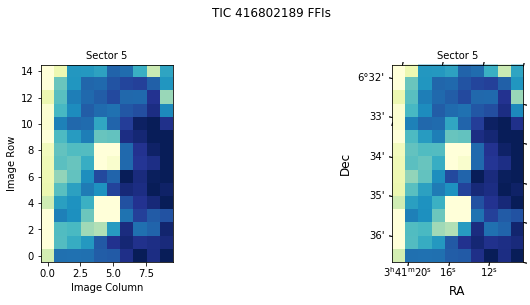

In [199]:

file ="data/tess-s0005-1-4_55.320459_6.560130_10x15_astrocut.fits"
fits.info(file)

fs=10
# with PdfPages('TIC_'+str(ID)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    # Reading in WCS coordinates and calibrated image
with fits.open(file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header
    
    Image = cal_image['FLUX'][0] 
    wcs = WCS(hdulist[2].header)
    aperture = hdulist[2].data
    
with PdfPages('TIC_'+str(ID)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    pltind = 221

    fig = plt.figure(figsize=(12, 8))

    fig.add_subplot(pltind).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(Image, 92),
           vmin = np.percentile(Image, 5))
    plt.ylabel('Image Row',fontsize = fs) 
    plt.xlabel('Image Column',fontsize = fs)
    plt.title("Sector "+str(hdulist[0].header['SECTOR']),fontsize = fs)


    fig.add_subplot(pltind+1,projection = wcs).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(Image, 92),
           vmin = np.percentile(Image, 5))
    
    plt.title("Sector "+str(hdulist[0].header['SECTOR']),fontsize = fs)
    plt.xlabel('RA', fontsize = 12)
    plt.ylabel('Dec', fontsize = 12)

    fig.suptitle('TIC '+str(ID)+' FFIs')
    fig.subplots_adjust(wspace=0.1)#,hspace=0.02)
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    pdf.savefig(bbox_inches='tight')
    plt.show()

# Reading in WCS coordinates and calibrated image
with fits.open(file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header
    

# Here is the same data set with a smaller cut out (5x5 instead of 15x10)

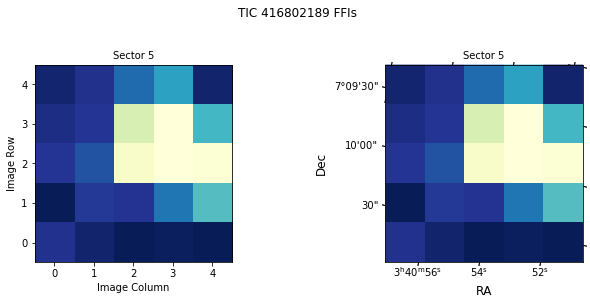

In [201]:
file = 'data/tess-s0005-1-4_55.224195_7.162489_5x5_astrocut.fits'
fs=10
# with PdfPages('TIC_'+str(ID)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    # Reading in WCS coordinates and calibrated image
with fits.open(file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header
    
    Image = cal_image['FLUX'][0] 
    wcs = WCS(hdulist[2].header)
    aperture = hdulist[2].data
    
with PdfPages('TIC_'+str(ID)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    pltind = 221

    fig = plt.figure(figsize=(12, 8))

    fig.add_subplot(pltind).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(Image, 92),
           vmin = np.percentile(Image, 5))
    plt.ylabel('Image Row',fontsize = fs) 
    plt.xlabel('Image Column',fontsize = fs)
    plt.title("Sector "+str(hdulist[0].header['SECTOR']),fontsize = fs)


    fig.add_subplot(pltind+1,projection = wcs).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(Image, 92),
           vmin = np.percentile(Image, 5))
    
    plt.title("Sector "+str(hdulist[0].header['SECTOR']),fontsize = fs)
    plt.xlabel('RA', fontsize = 12)
    plt.ylabel('Dec', fontsize = 12)

    fig.suptitle('TIC '+str(ID)+' FFIs')
    fig.subplots_adjust(wspace=0.1)#,hspace=0.02)
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    pdf.savefig(bbox_inches='tight')
    plt.show()

# Reading in WCS coordinates and calibrated image
with fits.open(file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header
    

# Below is a function to extract a light curve from the FITS file:

In [195]:
def TESScutFits_to_lightcurve(fits_file):
    
    rawt=[];rawf=[];rawe=[]
    bkgt=[];bkgf=[];bkge=[]
    T=[];F=[];E=[]

    with fits.open(fits_file, mode = "readonly") as hdu:
        wcs_info = WCS(hdu[1].header)
        cal_image = hdu[1].data
        header = hdu[1].header
        quality = hdu[1].data['QUALITY']

        Image = cal_image['FLUX'][0] 
        wcs = WCS(hdu[2].header)
        aperture = hdu[2].data ==1 #just for this case because cutout is so zoomed in


        #extract raw light curve
        f = make_lc(hdu[1].data['FLUX'], aperture)[0]
        e = make_lc(hdu[1].data['FLUX_ERR'], aperture)[0]
        t = hdu[1].data['TIME'] 

        t = t[~np.isnan(t)] # ~np.isnan() removes NaN (not a number) values from array. Sometimes weird things happen that cause this (telescope errors, known problems,etc).
        f = f[~np.isnan(f)]
        e = e[~np.isnan(e)]

        #removing bad quality data points
        m = np.where(quality==0)[0]
        t=t[m]
        f=f[m]
        e=e[m]

        #estimate background flux by checking dimmest pixels by using percentile.
        bkgAperture = hdu[1].data['FLUX'][0] < np.percentile(hdu[1].data['FLUX'][0], 5)

        bkgFlux = make_lc(hdu[1].data['FLUX'], bkgAperture)[0][m] #also apply quality mas
        bkgSubFlux = f - (bkgFlux * np.sum(aperture) / np.sum(bkgAperture) ) #subtracting background flux
        bkgSubFlux = bkgSubFlux[~np.isnan(bkgSubFlux)]

        #Normalize background subtracted flux
        NormFlux = bkgSubFlux/np.mean(bkgSubFlux)
        NormFlux = NormFlux[~np.isnan(NormFlux)]

        rawt=np.append(rawt,t)
        rawf=np.append(rawf,f)
        rawe=np.append(rawe,e)

        #Background flux data
        bkgFlux = bkgFlux[~np.isnan(bkgFlux)] 

        bkgt = np.append(bkgt,t)
        bkgf = np.append(bkgf,bkgFlux)
        bkge = np.append(bkge,e)


        #background subtracted and normalized data
        NormFlux = NormFlux[~np.isnan(NormFlux)]
        t = t[~np.isnan(NormFlux)]
        e = e[~np.isnan(NormFlux)]

        T = np.append(T,t)
        F = np.append(F,NormFlux)
        E = np.append(E,e)
        
    return T,F,E

# Here is how the two cutout sizes compare:

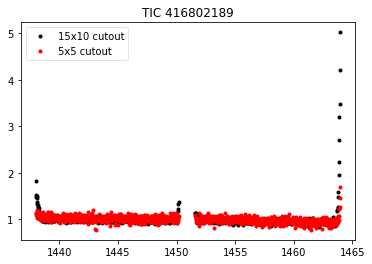

In [204]:

tt,ff,ee = TESScutFits_to_lightcurve("data/tess-s0005-1-4_55.224195_7.162489_10x15_astrocut.fits")
tt2,ff2,ee2 = TESScutFits_to_lightcurve("data/tess-s0005-1-4_55.224195_7.162489_5x5_astrocut.fits")
plt.plot(tt,ff,'k.',label='15x10 cutout')
plt.plot(tt2,ff2,'r.',label='5x5 cutout')
plt.legend(loc='best',fancybox=True,framealpha=0.5)
plt.title("TIC "+str(ID))
plt.show()
